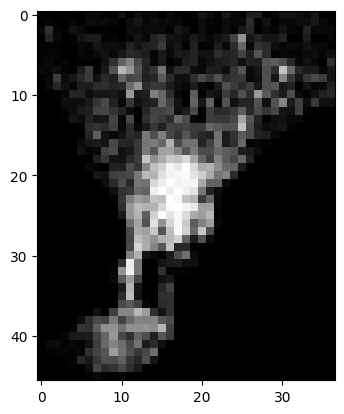

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  128 non-null    geometry
dtypes: geometry(1)
memory usage: 1.1 KB
None


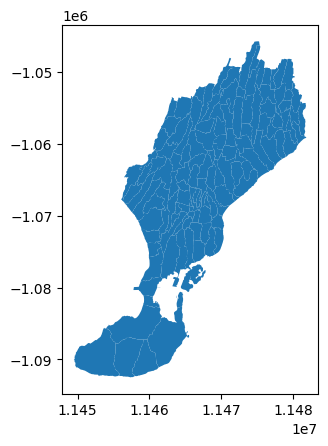

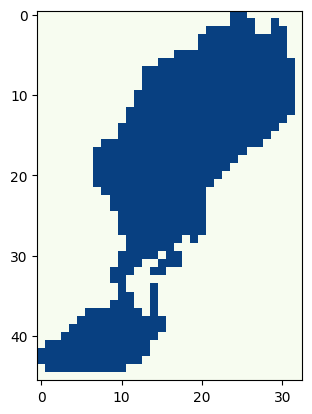

In [7]:
import folium.raster_layers
import rasterio
import rasterio.mask
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import CRS
import rasterio.transform
import folium
import numpy as np

# Load the raster data
raster = rasterio.open("built_up_denpasar.tif")

# Load the shapefile
shapefile = gpd.read_file("denpasar_metro_area.shp")

# Plot the raster data
plt.figure()
plt.imshow(raster.read(1), cmap='gray')
plt.show()
print(shapefile.info())

# Plot the shapefile
shapefile = shapefile.set_crs(epsg=4326)
target_crs = CRS.from_proj4('+proj=moll +lon_0=0 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
shapefile = shapefile.to_crs(target_crs)
shapefile.plot()

# Mask the raster with shapefile
out_image, out_transform = rasterio.mask.mask(raster, shapefile.geometry, crop=True)
out_meta = raster.meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# Save the masked raster and plot the final result using leaflet
with rasterio.open("masked_built_up_denpasar.tif", "w", **out_meta) as dest:
    dest.write(out_image)
    plt.figure()
    plt.imshow(out_image[0], cmap='GnBu')
    plt.show()

# Convert the masked area to GeoJSON
masked_area = gpd.GeoDataFrame(geometry=[shapefile.union_all()])
masked_area.crs = shapefile.crs
masked_area = masked_area.to_crs(epsg=4326)
geojson = masked_area.to_json()

# Create a map
m = folium.Map(location=[-8.65, 115.22], zoom_start=12)

# Add the masked area to the map
folium.GeoJson(geojson).add_to(m)

# Display the map
m.save("denpasar_map.html")
m



